In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data\AAPM21'
folder = 'CT resolution'

ct = np.load(os.path.join(directory, folder, 'Two', 'CT_norm.npy'))

masks = np.load(os.path.join(directory, folder, 'Two', 'mtf_masks.npy'))

c_vals = np.load(os.path.join(directory, folder, 'Two', 'mtf_contrast_vals.npz'))

contrast_vals = c_vals['contrast']
plastic_std = c_vals['std_1']
air_std = c_vals['std_2']

std_vals = np.zeros((6, 15))
for i in range(6):
    if i < 3:
        r = 2
    else:
        r = 1
    for s, ct_s in enumerate([11, 12, 13]):
        std_vals[i, s*5] = np.nanstd(ct[ct_s]*masks[i])
        std_vals[i, s*5+1] = np.nanstd(ct[ct_s]*np.roll(masks[i], r, axis=0))
        std_vals[i, s*5+2] = np.nanstd(ct[ct_s]*np.roll(masks[i], -r, axis=0))
        std_vals[i, s*5+3] = np.nanstd(ct[ct_s]*np.roll(masks[i], r, axis=1))
        std_vals[i, s*5+4] = np.nanstd(ct[ct_s]*np.roll(masks[i], -r, axis=1))

In [19]:
bar_size = np.array([1, 0.75, 0.66, 0.5, 0.33, 0.25])  # [mm] spot sizes for CT resolution phantom

# calculate the frequency in line pairs per mm or use the known freq
freq = 1 / (2 * bar_size)

mtf_final = []
for i in range(15):
    # M' is the measured noise (STD) in each of the bar patterns, uncorrected
    M_prime = std_vals[:, i]

    # squared noise using ROIs of air and plastic
    # N^2 = (Np^2+Nw^2)/2
    noise_2 = (air_std ** 2 + plastic_std ** 2) / 2
    # correct std of bar patterns for noise using the water ROI, M = sqrt(M'^2-N^2)
    M = []
    for std in M_prime:
        if std ** 2 > noise_2:
            M.append(np.sqrt(std ** 2 - noise_2))
        else:
            M.append(0)

    # M = np.array([np.sqrt(std_16**2-noise_2),np.sqrt(std_13**2-noise_2),np.sqrt(std_10**2-noise_2),
    #             np.sqrt(std_08**2-noise_2),np.sqrt(std_06**2-noise_2),np.sqrt(std_05**2-noise_2)])

    # M0 = (CT1-CT2)/2: |Air - Plastic|/2
    M0 = contrast_vals / 2

    # MTF = (pi*sqrt(2)/4)*(M/M0)
    MTF = (np.pi * np.sqrt(2) / 4) * (M / M0)
    mtf_final.append(MTF)

mtf_final = np.array(mtf_final)

mtf_mean = np.mean(mtf_final, axis=0)
mtf_std = np.std(mtf_final, axis=0)

Limiting resolution: 1.33 lp/mm, 0.375 mm


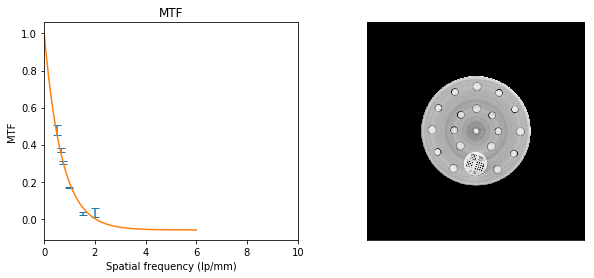

In [22]:
# Do a curve fit with exponential
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

freq_fit = np.linspace(0, 6, 100)

popt, pcov = curve_fit(func, np.insert(freq, 0, 0), np.insert(mtf_mean, 0, 1))

# Find the 0.1 spot
mtf_new = func(freq_fit, *popt)
idx = np.abs(mtf_new - 0.1).argmin()
print(f'Limiting resolution: {freq_fit[idx]:0.2f} lp/mm, {1/(2*freq_fit[idx]):0.3f} mm')


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].errorbar(freq, mtf_mean, yerr=mtf_std, capsize=4, fmt='none')
ax[0].plot(freq_fit, mtf_new)
ax[0].set_title('MTF')
ax[0].set_ylabel('MTF')
ax[0].set_xlabel('Spatial frequency (lp/mm)')
ax[0].set_xlim([0, 10])

ax[1].imshow(ct[13], vmin=-800, vmax=100, cmap='gray')
ax[1].axes.xaxis.set_ticks([])
ax[1].axes.yaxis.set_ticks([])
ax[1].grid(False)
plt.show()

# Save the MTF
np.save(os.path.join(directory, folder, 'mtf.npy'), np.array([freq, MTF]))